The code

Training MAML with checkpoints...



00%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [06:22<00:00, 52.23it/s]

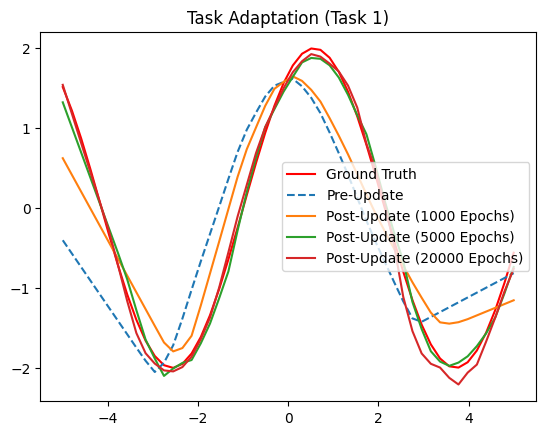

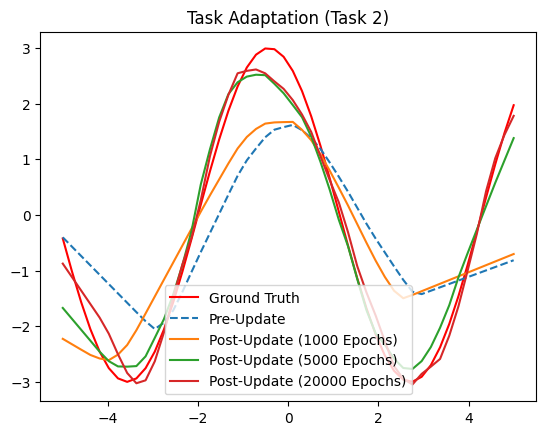

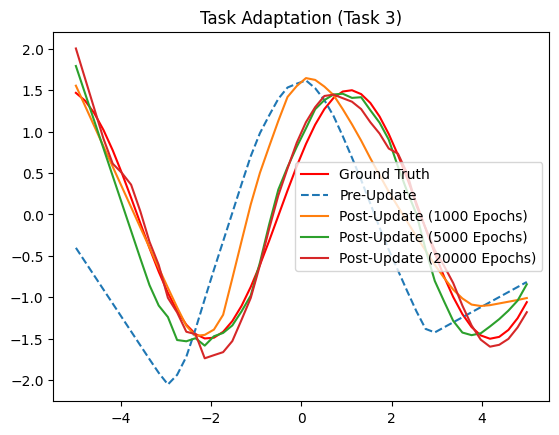

In [3]:
# code of 3 Fast Adaption Tasks


#import of necessary libraries
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.autograd import grad


def mlp(x, params):
    h = torch.relu(torch.nn.functional.linear(x, params[0], bias=params[1]))
    h = torch.relu(torch.nn.functional.linear(h, params[2], bias=params[3]))
    return torch.nn.functional.linear(h, params[4], bias=params[5])

class Task:
    def __init__(self, a, b):
        self.a = a
        self.b = b

    def sample(self, K):
        x = torch.rand((K, 1)) * 10 - 5  # Sample x in [-5, 5]
        y = self.a * torch.sin(x + self.b)
        loss_fct = nn.MSELoss()
        return x, y, loss_fct

@torch.no_grad()
def sample_task(a=None, b=None):
    if a is None:
        a = torch.rand(1).item() * 4.9 + .1  # Amplitude in [0.1, 5.0]
    if b is None:
        b = torch.rand(1).item() * np.pi  # Phase in [0, pi]
    return Task(a, b)

def perform_k_training_steps(params, task, batch_size, inner_training_steps, alpha, device='cpu'):
    for epoch in range(inner_training_steps):
        x_batch, target, loss_fct = task.sample(batch_size)
        loss = loss_fct(mlp(x_batch.to(device), params), target.to(device))

        for p in params:
            p.grad = None
        gradients = grad(loss, params)
        for p, g in zip(params, gradients):
            p.data -= alpha * g
    return params

def maml(p_model, meta_optimizer, inner_training_steps, nb_epochs, batch_size_K, alpha, nb_tasks=10, device='cpu', checkpoints=None):
    training_loss = []
    checkpoint_data = {c: [] for c in checkpoints} if checkpoints else {}
    
    for epoch in tqdm(range(1, nb_epochs + 1)):
        theta_i_prime = []
        D_i_prime = []

        # Sample batch of tasks
        tasks = [sample_task() for _ in range(nb_tasks)]
        for task in tasks:
            theta_i_prime.append(perform_k_training_steps([p.clone() for p in p_model], task, batch_size_K,
                                                          inner_training_steps, alpha, device=device))
            x, y, loss_fct = task.sample(25)
            D_i_prime.append((x, y, loss_fct))

        meta_optimizer.zero_grad()
        batch_training_loss = []

        for i in range(nb_tasks):
            x, y, loss_fct = D_i_prime[i]
            f_theta_prime = theta_i_prime[i]
            task_output = mlp(x.to(device), f_theta_prime)
            loss = loss_fct(task_output, y.to(device))
            loss.backward()
            batch_training_loss.append(loss.item())

        meta_optimizer.step()
        training_loss.append(np.mean(batch_training_loss))

        # Save checkpoint data
        if checkpoints and epoch in checkpoints:
            checkpoint_data[epoch] = {
                "params": [p.clone() for p in p_model],
                "loss": training_loss.copy()
            }

    return training_loss, checkpoint_data

if __name__ == "__main__":
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Initialize model parameters
    params = [
        torch.rand(40, 1, device=device).uniform_(-np.sqrt(6. / 41), np.sqrt(6. / 41)).requires_grad_(),
        torch.zeros(40, device=device).requires_grad_(),
        torch.rand(40, 40, device=device).uniform_(-np.sqrt(6. / 80), np.sqrt(6. / 80)).requires_grad_(),
        torch.zeros(40, device=device).requires_grad_(),
        torch.rand(1, 40, device=device).uniform_(-np.sqrt(6. / 41), np.sqrt(6. / 41)).requires_grad_(),
        torch.zeros(1, device=device).requires_grad_()
    ]

    meta_optimizer = torch.optim.Adam(params, lr=1e-3)

    # Fixed tasks with predefined parameters
    fixed_tasks = [
        sample_task(a=2.0, b=1.0),
        sample_task(a=3.0, b=2.0),
        sample_task(a=1.5, b=0.5)
    ]

    # Checkpoints to capture intermediate results
    checkpoints = [1000, 5000, 20000]

    # Run MAML with checkpoints
    print("Training MAML with checkpoints...")
    _, checkpoint_data = maml(params, meta_optimizer, 1, 20000, 10, 1e-3, device=device, checkpoints=checkpoints)

    for task_idx, task in enumerate(fixed_tasks):
        x = torch.linspace(-5, 5, 50).to(device)
        ground_truth_y = task.a * torch.sin(x + task.b)

        plt.title(f'Task Adaptation (Task {task_idx + 1})')
        plt.plot(x.cpu().numpy(), ground_truth_y.cpu().numpy(), c='red', label='Ground Truth')

        y_pre = mlp(x[..., None], checkpoint_data[1000]["params"]).detach()
        plt.plot(x.cpu().numpy(), y_pre.cpu().numpy(), linestyle='--', label='Pre-Update')

        for checkpoint in checkpoints:
            # Post-Update predictions
            new_params = perform_k_training_steps([p.clone() for p in checkpoint_data[checkpoint]["params"]], task, 10, 10, 1e-3, device=device)
            y_post = mlp(x[..., None], new_params).detach()
            plt.plot(x.cpu().numpy(), y_post.cpu().numpy(), label=f'Post-Update ({checkpoint} Epochs)')

        plt.legend()
        plt.savefig(f'task_adaptation_task{task_idx + 1}.png')
        plt.show()



00%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [06:30<00:00, 51.28it/s]

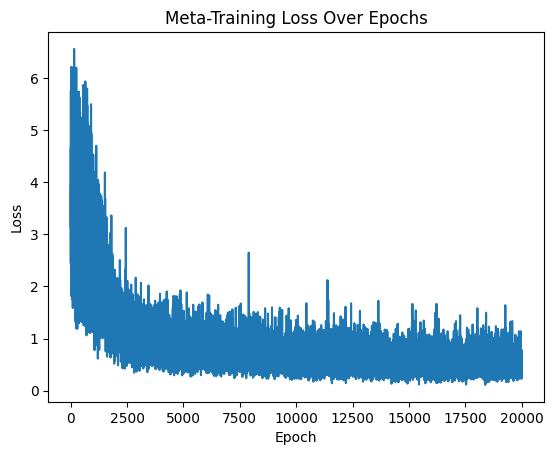

In [2]:
#code of generating plot of loss adaption over 70000 epochs
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.autograd import grad

def mlp(x, params):
    h = torch.relu(torch.nn.functional.linear(x, params[0], bias=params[1]))
    h = torch.relu(torch.nn.functional.linear(h, params[2], bias=params[3]))
    return torch.nn.functional.linear(h, params[4], bias=params[5])

class Task:
    def __init__(self, a, b):
        self.a = a
        self.b = b

    def sample(self, K):
        x = torch.rand((K, 1)) * 10 - 5  # Sample x in [-5, 5]
        y = self.a * torch.sin(x + self.b)
        loss_fct = nn.MSELoss()
        return x, y, loss_fct

@torch.no_grad()
def sample_task():
    a = torch.rand(1).item() * 4.9 + .1  # Amplitude in [0.1, 5.0]
    b = torch.rand(1).item() * np.pi  # Phase in [0, pi]
    return Task(a, b)

def perform_k_training_steps(params, task, batch_size, inner_training_steps, alpha, device='cpu'):
    for epoch in range(inner_training_steps):
        x_batch, target, loss_fct = task.sample(batch_size)
        loss = loss_fct(mlp(x_batch.to(device), params), target.to(device))

        for p in params:
            p.grad = None
        gradients = grad(loss, params)
        for p, g in zip(params, gradients):
            p.data -= alpha * g
    return params

def maml(p_model, meta_optimizer, inner_training_steps, nb_epochs, batch_size_K, alpha, nb_tasks=10, device='cpu'):
    training_loss = []
    for epoch in tqdm(range(nb_epochs)):
        theta_i_prime = []
        D_i_prime = []

        # Sample batch of tasks
        tasks = [sample_task() for _ in range(nb_tasks)]
        for task in tasks:
            theta_i_prime.append(perform_k_training_steps([p.clone() for p in p_model], task, batch_size_K,
                                                          inner_training_steps, alpha, device=device))
            x, y, loss_fct = task.sample(25)
            D_i_prime.append((x, y, loss_fct))

        meta_optimizer.zero_grad()
        batch_training_loss = []
        cached_task_outputs = []  # Cache outputs for efficiency

        for i in range(nb_tasks):
            x, y, loss_fct = D_i_prime[i]
            f_theta_prime = theta_i_prime[i]
            task_output = mlp(x.to(device), f_theta_prime)
            cached_task_outputs.append(task_output)
            loss = loss_fct(task_output, y.to(device))
            loss.backward()
            batch_training_loss.append(loss.item())

        meta_optimizer.step()
        training_loss.append(np.mean(batch_training_loss))
    return training_loss


if __name__ == "__main__":
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Initialize model parameters
    params = [
        torch.rand(40, 1, device=device).uniform_(-np.sqrt(6. / 41), np.sqrt(6. / 41)).requires_grad_(),
        torch.zeros(40, device=device).requires_grad_(),
        torch.rand(40, 40, device=device).uniform_(-np.sqrt(6. / 80), np.sqrt(6. / 80)).requires_grad_(),
        torch.zeros(40, device=device).requires_grad_(),
        torch.rand(1, 40, device=device).uniform_(-np.sqrt(6. / 41), np.sqrt(6. / 41)).requires_grad_(),
        torch.zeros(1, device=device).requires_grad_()
    ]

    meta_optimizer = torch.optim.Adam(params, lr=1e-3)

    # Meta-training with 70,000 epochs and fixed alpha (inner learning rate)
    training_loss = maml(params, meta_optimizer, 1, 70000, 10, 1e-3, device=device, nb_tasks=10)

    # Plot meta-training loss curve
    plt.plot(training_loss)
    plt.title('Meta-Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('meta_training_loss.png')
    plt.show()